# Analyse Morris results

In [2]:
import pandas as pd
import seaborn as sns
import re
from matplotlib import pyplot as plt
from pathlib import Path

Run with `dakota -i morris_lt.in > morris_summary.out`: only `>` gets summary results written to file (the actual analysed results of the evaluations).

In [3]:
# Must be am easier way to get Dakota results out? Apparently not
# Read in .out file (contains summary results)
output_files = ["morris_lt_summary.out", "morris_lt_max_q_summary.out"]

# Match line in output
input_re = re.compile(r"Input\s+(\d+)\s.*=\s+(\d+\.\d+e[+-]\d+)\s+(\d+\.\d+e[+-]\d+)")
end_of_results_re = re.compile(r"^$")
results = {"design": [], "input": [], "descriptor": [], "mod_mean": [], "std": []}

# Morris OAT in Dakota doesn't provide descriptors for each param: only
# "Input 1" etc. in summary output
# This descriptor list is in same order as input file continuous design descriptors
# Only way of matching the two apparently
descriptors = [
    "fdene",
    "hfact",
    "coreradius",
    "ralpne",
    "fimp_14",
    "psepbqarmax",
    "flhthresh",
    "cboot",
    "peakfactrad",
    "kappa",
    "etaech",
    "feffcd",
    "etath",
    "etaiso",
    "boundl_18",
    "pinjalw",
    "alstroh",
    "sig_tf_wp_max",
    "boundu_2",
    "triang",
]

# Find the first set of summary results in .out file, which corresponds to w
# Subsequent summary results correspond to individual constraints
# Due to ordering of responses in .in file
for output_file in output_files:
    design_and_suffix = output_file.split("morris_")[1]
    design = design_and_suffix.split("_summary.out")[0]
    with open(output_file, "r") as f:
        content = f.readlines()

    got_results = False
    for line in content:
        if matches := input_re.match(line):
            got_results = True
            # Start of results
            results["design"].append(design)
            results["input"].append(int(matches[1]))
            # "Input 1" is descriptor[0]
            results["descriptor"].append(descriptors[int(matches[1]) - 1])
            results["mod_mean"].append(float(matches[2]))
            results["std"].append(float(matches[3]))
        elif got_results and end_of_results_re.match(line):
            # Got first set of results (w), ignore others (individual constraints), now exit
            break
        else:
            # Not reached results in file yet
            continue

results_df = pd.DataFrame(results)
results_df

,design,input,descriptor,mod_mean,std
0,lt,1,fdene,0.000000,0.000000
1,lt,2,hfact,0.000000,0.000000
2,lt,3,coreradius,0.000000,0.000000
3,lt,4,ralpne,37717.000000,67017.000000
4,lt,5,fimp_14,44687.000000,71466.000000
5,lt,6,psepbqarmax,0.000000,0.000000
6,lt,7,flhthresh,2340.400000,7927.900000
7,lt,8,cboot,0.830190,1.476500
8,lt,9,peakfactrad,0.000000,0.000000
9,lt,10,kappa,187.420000,506.370000


In [4]:
# Order by mod mean: most influential params (use for full variance-based SA)
mod_mean_df = (
    results_df.sort_values(by="mod_mean", ascending=False).groupby("design").head(8)
)
mod_mean_df

,design,input,descriptor,mod_mean,std
24,lt_max_q,5,fimp_14,73024.000000,96813.000000
23,lt_max_q,4,ralpne,48778.000000,86244.000000
4,lt,5,fimp_14,44687.000000,71466.000000
3,lt,4,ralpne,37717.000000,67017.000000
29,lt_max_q,10,kappa,36920.000000,73414.000000
26,lt_max_q,7,flhthresh,4494.900000,12140.000000
6,lt,7,flhthresh,2340.400000,7927.900000
39,lt_max_q,20,triang,217.450000,448.580000
9,lt,10,kappa,187.420000,506.370000
27,lt_max_q,8,cboot,48.243000,122.640000


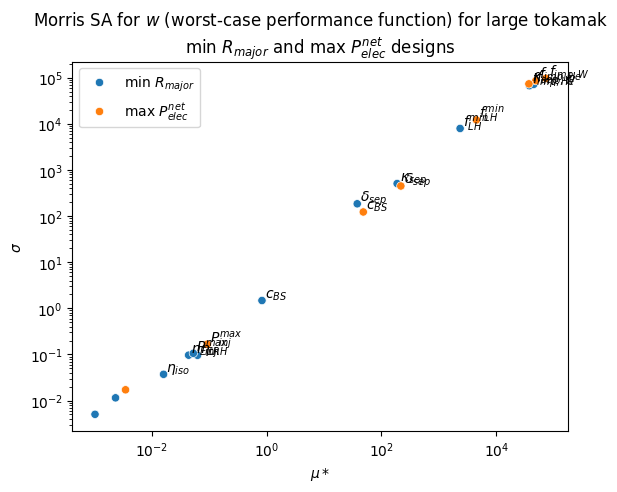

In [5]:
# Plot both designs together
ax = sns.scatterplot(data=results_df, x="mod_mean", y="std", hue="design")

param_latex = {
    "fdene": r"$f^{max}_{GW}$",
    "hfact": r"$H_{98, y2}$",
    "coreradius": r"$\rho_{core}$",
    "ralpne": r"$f_{imp, He}$",
    "fimp_14": r"$f_{imp, W}$",
    "psepbqarmax": r"$\frac{P_{sep}B_T}{qAR_0}^{max}$",
    "flhthresh": r"$f^{min}_{LH}$",
    "cboot": r"$c_{BS}$",
    "peakfactrad": r"$\tau^{max}_{rad}$",
    "kappa": r"$\kappa_{sep}$",
    "etaech": r"$n_{ECRH}$",
    "feffcd": r"$f_{CD}$",
    "etath": r"$\eta_{th}$",
    "etaiso": r"$\eta_{iso}$",
    "boundl_18": r"$q^{min}_{95}$",
    "pinjalw": r"$P^{max}_{inj}$",
    "alstroh": r"$\sigma^{max}_{CS}$",
    "sig_tf_wp_max": r"$\simga^{max}_{TF}$",
    "boundu_2": r"$B^{max}_{T}$",
    "triang": r"$\delta_{sep}$",
    "higher_order": "$S_{higher}$",
}


def label_point(df, annotation_offsets=None):
    others = False
    for _, row in df.iterrows():
        mod_mean = row["mod_mean"]
        std = row["std"]
        param = row["descriptor"]
        param_symbol = param_latex[param]
        # Only label if not 0: avoid overwriting at same point
        if mod_mean >= 0.01 and std >= 0.01:
            # Annotate. Is there an offset for this point?
            if annotation_offsets and annotation_offsets.get(param):
                # Annotate with offset
                x_offset = annotation_offsets[param][0]
                y_offset = annotation_offsets[param][1]
                ax.annotate(
                    text=param_symbol,
                    xy=(mod_mean, std),
                    xytext=(x_offset, y_offset),
                    textcoords="axes fraction",
                    arrowprops=dict(
                        arrowstyle="-",
                    ),
                )
            else:
                # Annotate exactly on point
                ax.annotate(
                    text=param_symbol,
                    xy=(mod_mean, std),
                    xytext=(2, 2),
                    textcoords="offset points",
                )
        elif others is False:
            ax.annotate(
                text="Other",
                xy=(mod_mean, std),
                xytext=(4, 4),
                textcoords="offset points",
            )
            others = True


ax.loglog()
label_point(results_df)
ax.set_title(
    "Morris SA for $w$ (worst-case performance function) for large tokamak\nmin $R_{major}$"
    " and max $P_{elec}^{net}$ designs"
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

label_map = {"lt": "min $R_{major}$", "lt_max_q": "max $P_{elec}^{net}$"}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [label_map[l] for l in labels])

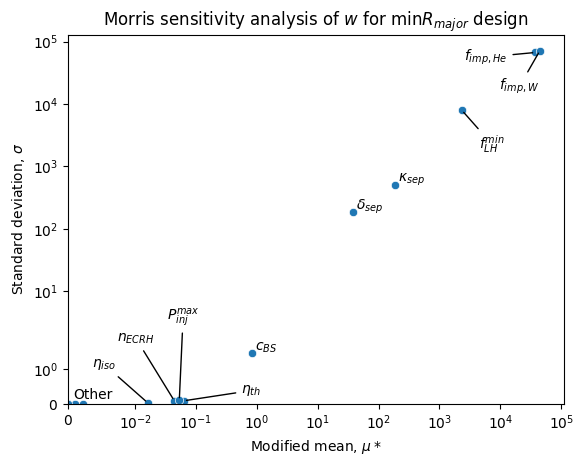

In [10]:
# min rmajor only
lt_results_df = results_df[results_df["design"] == "lt"]
ax = sns.scatterplot(data=lt_results_df, x="mod_mean", y="std")

annotation_offsets = {
    "ralpne": [0.8, 0.93],
    "fimp_14": [0.87, 0.85],
    "flhthresh": [0.83, 0.69],
    "etaiso": [0.05, 0.1],
    "etaech": [0.1, 0.17],
    "pinjalw": [0.2, 0.23],
    "etath": [0.35, 0.03],
}
label_point(lt_results_df, annotation_offsets=annotation_offsets)
ax.set_title("Morris sensitivity analysis of $w$ for $\min R_{major}$ design")
ax.set_xlabel("Modified mean, $\mu*$")
ax.set_ylabel("Standard deviation, $\sigma$")
ax.ticklabel_format(style="sci", scilimits=(0, 0), useMathText=True)
# ax.loglog()
# loglog doesn't plot params with 0 values: want to show this values
ax.set_xscale("symlog", linthresh=0.01)
ax.set_yscale("symlog")
# Loads of -ve space and points crunched up in top corner otherwise: both plots same scales
ax.set_xlim(0, 1.1e5)
ax.set_ylim(0, 1.3e5)

# Save to figs dir
figs_dir = Path.home() / "Desktop" / "interval_analysis_presentation_figs"
plt.savefig(figs_dir / "morris_lt_min_rmajor.pdf", bbox_inches="tight")

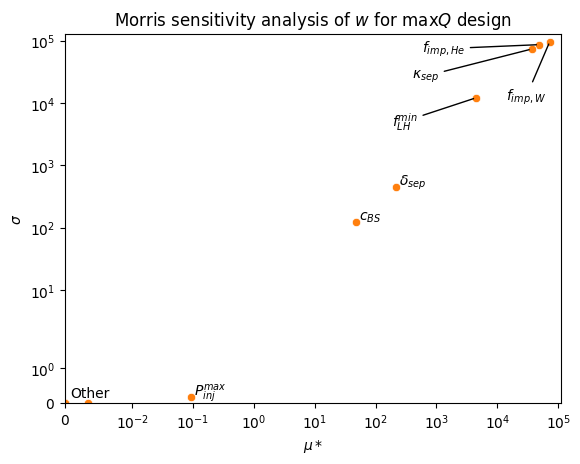

In [7]:
# Max P net elec only
lt_max_net_elec_results_df = results_df[results_df["design"] == "lt_max_q"]
ax = sns.scatterplot(data=lt_max_net_elec_results_df, x="mod_mean", y="std", color="C1")
annotation_offsets = {
    "ralpne": [0.72, 0.95],
    "fimp_14": [0.89, 0.82],
    "flhthresh": [0.66, 0.75],
    "etath": [0.35, 0.03],
    "kappa": [0.7, 0.88],
}
label_point(lt_max_net_elec_results_df, annotation_offsets=annotation_offsets)
ax.set_title("Morris sensitivity analysis of $w$ for $\max Q$ design")
ax.set_xlabel("Modified mean, $\mu*$")
ax.set_ylabel("Standard deviation, $\sigma$")
ax.ticklabel_format(style="sci", scilimits=(0, 0), useMathText=True)
# ax.loglog()
# loglog doesn't plot params with 0 values: want to show this values
ax.set_xscale("symlog", linthresh=0.01)
ax.set_yscale("symlog")
# Loads of -ve space and points crunched up in top corner otherwise
ax.set_xlim(0, 1.1e5)
ax.set_ylim(0, 1.3e5)
plt.savefig(figs_dir / "morris_lt_max_q.pdf", bbox_inches="tight")

## Individual constraint analysis

**Don't bother with here**

In [8]:
# Read in individual evaluations
# evals = pd.read_csv("morris_lt.dat", sep="\s+")
# evals_described = evals.describe()
# evals_w_sorted = evals.sort_values(by="w", ascending=False)
# Nothing too badly violated

evals = pd.read_csv("morris_lt_max_q.dat", sep="\s+")
# Drop interface column; str and not useful
evals.drop(labels="interface", axis=1, inplace=True)

# Describe responses
responses_re = r"(^w$|eq_con\d{3})"
parameters_re = r"^(?!(w$|\w*eq_con\d{3}))"
responses = evals.filter(regex=responses_re)
responses.describe()

,w
count,506.000000
mean,38839.375295
std,56924.597496
min,-0.000002
25%,0.320000
50%,1.848363
75%,107599.939700
max,141037.301500


Looks like `ineq_con015` is the one with the huge violation value. Find programmatically:

In [9]:
# Find constraint that is w (worst violated)
print(
    "Worst-violated constraint: "
    # Returns [w, constraint_name]
    + responses.columns[responses.eq(responses["w"].max()).any(axis=0)]
    + " = "
    + str(responses["w"].max())
)

# Find parameters causing max w
# Find rows containing max w, then filter for parameter columns only
max_w_rows = evals[responses.eq(responses["w"].max()).any(axis=1)].filter(
    regex=parameters_re
)
# Which parameters are staying constant?
# eyeballing: fimp_14 and triang always look similar in max w case
# Use mean-normalised std
max_w_rows.loc[:, max_w_rows.std() / max_w_rows.mean() < 0.01].describe()
max_w_rows.loc[:, max_w_rows.std() / max_w_rows.mean() < 0.01]

Index(['Worst-violated constraint: w = 141037.3015'], dtype='object')


,ralpne,fimp_14,flhthresh,cboot,kappa,aspect,triang
298,0.095,0.0001,1.15,1.05,1.9,3.0,0.4
299,0.095,0.0001,1.15,1.05,1.9,3.0,0.4
300,0.095,0.0001,1.15,1.05,1.9,3.0,0.4
301,0.095,0.0001,1.15,1.05,1.9,3.0,0.4
302,0.095,0.0001,1.15,1.05,1.9,3.0,0.4
303,0.095,0.0001,1.15,1.05,1.9,3.0,0.4
304,0.095,0.0001,1.15,1.05,1.9,3.0,0.4
330,0.095,0.0001,1.15,1.05,1.9,3.0,0.4
331,0.095,0.0001,1.15,1.05,1.9,3.0,0.4


High fimp_14 and low triang cause the max w value (high constraint violation). Check row 16 (run 17 in Dakota). Constraint 15 ~1e5. What causes this? `con15 = plhthresh / pdivt`:
```
(plhthresh)___________________      1.3247590122539455E+02 OP
(pdivt)_______________________      1.0000000000000000E-03 OP
```
plhthresh is reasonable (131 MW), but pdivt is very low. Currently resting on a kludge to keep positive. This is the reason for high violation of constraint 15, and hence high $w$.